In [21]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.optim as optim
import time

In [22]:

# Define data transforms for the training and test sets
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [23]:
# Load the CIFAR-10 training and test sets using torchvision
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
# Create data loaders for the training and test sets
train_loader = DataLoader(dataset=train_dataset, batch_size=10,
                           shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=10,
                          shuffle=False, num_workers=2)

In [25]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        
    def forward(self, x):
        x = self.bn1(self.pool(torch.relu(self.conv1(x))))
        x = self.bn2(self.pool(torch.relu(self.conv2(x))))
        x = self.bn3(self.pool(torch.relu(self.conv3(x))))
        
        x = x.view(-1, 128 * 4 * 4)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        
        return x

In [26]:
Anet = AlexNet()

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Anet.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(Anet.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Anet.to(device)

AlexNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
train_losses = []
validation_losses = []

start_time = time.time()
num_epochs = 10
# Train the network
for epoch in range(num_epochs):
    iterative_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = Anet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        iterative_loss += loss.item()
        if i % 1000 == 999:    # Print every 100 mini-batches
            print('[Epoch %d, Iteration %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, iterative_loss / 100))
            iterative_loss = 0.0
            
    train_losses.append((iterative_loss*32)/len(train_loader))
    
    running_loss = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images,labels = images.to(device),labels.to(device)
            outputs = Anet(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
    validation_losses.append((running_loss*32)/len(test_loader))

print('Finished Training')
print("Time taken to train is %s seconds" % (time.time() - start_time))

[Epoch 1, Iteration  1000] Loss: 23.070
[Epoch 1, Iteration  2000] Loss: 21.194
[Epoch 1, Iteration  3000] Loss: 20.827
[Epoch 1, Iteration  4000] Loss: 20.638
[Epoch 1, Iteration  5000] Loss: 20.498
[Epoch 2, Iteration  1000] Loss: 20.222
[Epoch 2, Iteration  2000] Loss: 20.110
[Epoch 2, Iteration  3000] Loss: 19.896
[Epoch 2, Iteration  4000] Loss: 19.761
[Epoch 2, Iteration  5000] Loss: 19.708
[Epoch 3, Iteration  1000] Loss: 19.603
[Epoch 3, Iteration  2000] Loss: 19.497
[Epoch 3, Iteration  3000] Loss: 19.364
[Epoch 3, Iteration  4000] Loss: 19.296
[Epoch 3, Iteration  5000] Loss: 19.268
[Epoch 4, Iteration  1000] Loss: 19.245
[Epoch 4, Iteration  2000] Loss: 19.160
[Epoch 4, Iteration  3000] Loss: 19.139
[Epoch 4, Iteration  4000] Loss: 19.046
[Epoch 4, Iteration  5000] Loss: 19.088
[Epoch 5, Iteration  1000] Loss: 19.051
[Epoch 5, Iteration  2000] Loss: 18.963
[Epoch 5, Iteration  3000] Loss: 18.914
[Epoch 5, Iteration  4000] Loss: 18.908
[Epoch 5, Iteration  5000] Loss: 18.859


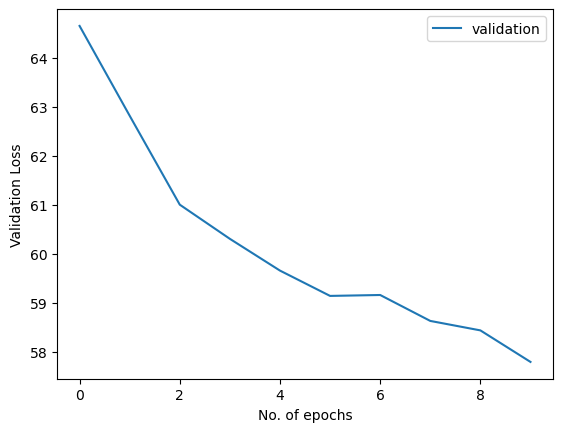

In [29]:
plt.plot(validation_losses, label = 'validation')
plt.xlabel('No. of epochs')
plt.ylabel('Validation Loss')
plt.legend()

In [30]:
with torch.no_grad():
    Anet.eval()  # switch to evaluation mode
    test_accuracy = 0.0
    total_samples = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = Anet(images)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        
        test_accuracy += correct
        total_samples += labels.size(0)
    
    test_accuracy /= total_samples
    test_accuracy *= 100.0
    
print('Accuracy of the network on the 10000 test images: %f %%' % test_accuracy)

Accuracy of the network on the 10000 test images: 54.090000 %
